# MazeDrone with TF Agents - 01 Crash Counter with Different Rewards

This notebook aims to develop an automatic test to verify how the agent performs, crash-wise, with different rewards during the first stage of training (without walls).

**Rewards:**
- destroyed = 
- stuck = 
- reached_target = 
- standard =

### Setup

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

from __future__ import absolute_import, division, print_function



import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

2024-09-14 11:23:40.015724: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 11:23:40.020866: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 11:23:40.121214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 11:23:41.496056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameters

In [2]:
num_iterations = 1_000 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

### Environment

In [3]:
sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

In [4]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([1., 1., 0., 1., 1., 0.], dtype=float32)})

Usually two environments are instantiated: one for training and one for evaluation.

In [5]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent

In [6]:
from resources import build_agent

fc_layer_params = (200,) # fc = fully connected
agent = build_agent(fc_layer_params, env, learning_rate, train_env)

agent.initialize()

### Policies


In [7]:
# The main policy that is used for evaluation and deployment.
eval_policy = agent.policy
# A second policy that is used for data collection.
collect_policy = agent.collect_policy

### Metrics and Evaluation

In [8]:
from resources import compute_avg_return

### New Observer

In [9]:
from resources import MyMetric

# Create an instance of MyMetric
my_metric = MyMetric()

### Replay Buffer

In [10]:
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

In [11]:
replay_buffer_capacity = replay_buffer_max_length

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()

# Add an observer that adds to the replay buffer:
replay_observer = [replay_buffer.add_batch, num_episodes, env_steps, my_metric]

### Data Collection

In [12]:
# Data collection:
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [13]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=train_env.batch_size,
    num_steps=2).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [14]:
iterator = iter(dataset)

### Training the Agent

In [15]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(1)
eval_py_env.set_mode(1)

# Create a driver to collect experience.
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

iterator = iter(dataset)

loss_log = []
step_log = []
steps_per_episode_log = []
episodes_per_log_interval = []
previous_n_episodes = 0

my_metric_log = []
my_metric_aux = 0

avg_steps_per_episode_per_eval_interval = []

train_py_env.print_rewards()

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run()

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=train_env.batch_size,
        num_steps=2).prefetch(3)
        
    # Sample a batch of data from the buffer and update the agent's network.
    trajectories, _ = next(iterator)
    train_loss = agent.train(experience=trajectories).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        #print('step = {0}: loss = {1}'.format(step, train_loss))
        step_log.append(step)
        loss_log.append(train_loss)
        episodes_per_log_interval.append(num_episodes.result().numpy() - previous_n_episodes)
        steps_per_episode_log.append(log_interval / (episodes_per_log_interval[-1]))
        previous_n_episodes = num_episodes.result().numpy()

    if step % eval_interval == 0:
        #print('step = {0}: loss = {1}'.format(step, train_loss))
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        #print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        avg_steps_per_episode_per_eval_interval.append(eval_interval / sum(episodes_per_log_interval[-10:]))
        #print('Avg of Steps/Episode: {:.2f}'.format(avg_steps_per_episode_per_eval_interval[-1]) )

        current_value = my_metric.result()
        my_metric_log.append(current_value)
        print('step = {0}: Crash = {1}'.format(step, current_value - my_metric_aux))
        my_metric_aux = current_value

Rewards: {'destroyed': -6.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 100: Crash = 62
step = 200: Crash = 42
step = 300: Crash = 42
step = 400: Crash = 22
step = 500: Crash = 23
step = 600: Crash = 30
step = 700: Crash = 24
step = 800: Crash = 11
step = 900: Crash = 13
step = 1000: Crash = 13
CPU times: user 2min 41s, sys: 1.39 s, total: 2min 43s
Wall time: 2min 39s


## Visualization

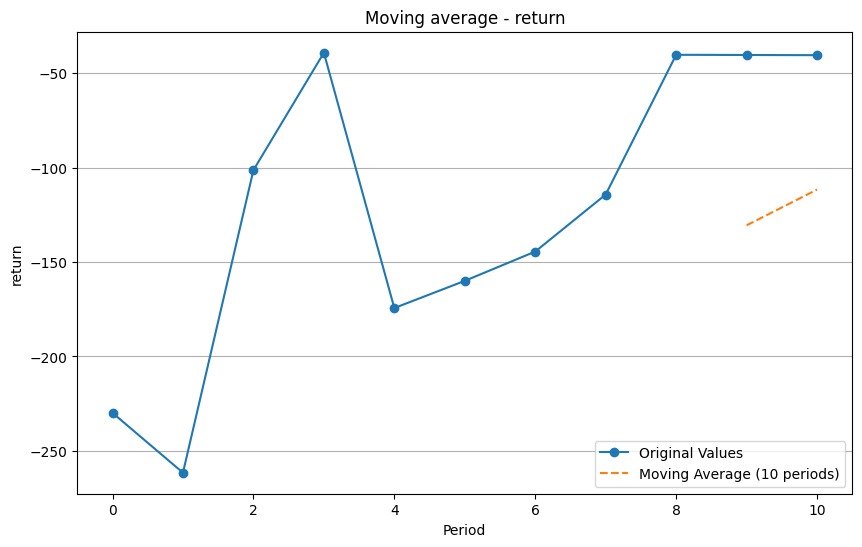

In [16]:
from resources import plot_moving_avg, plot_metric_per_iteration
plot_moving_avg('return', returns)

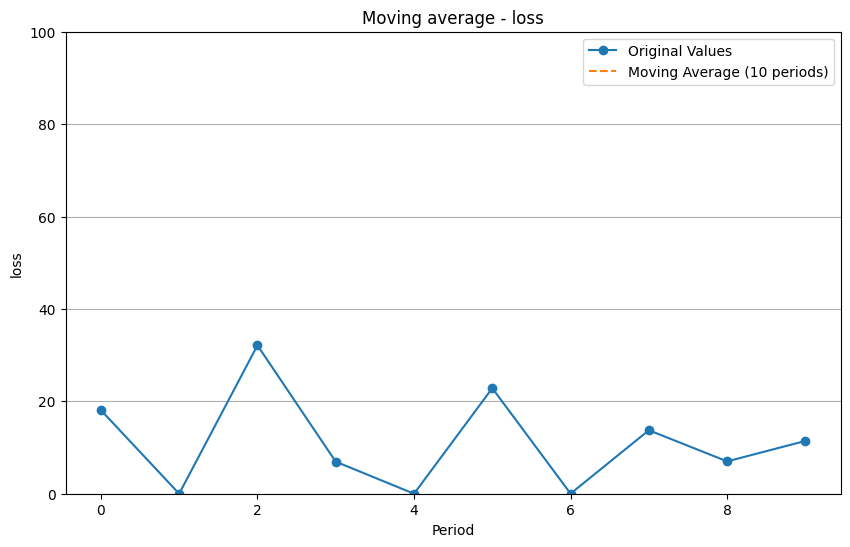

In [17]:
plot_moving_avg('loss', loss_log, ylim=True, top_lim=1_00)

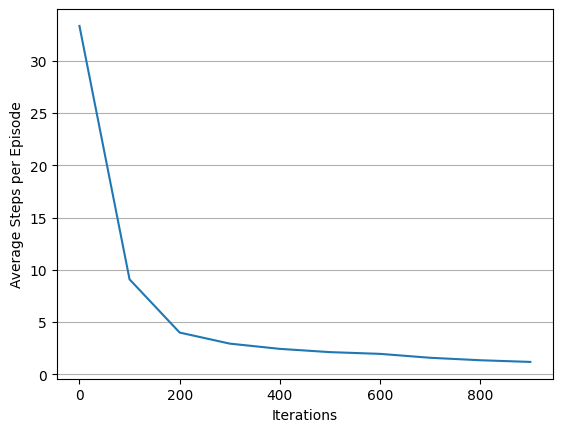

In [18]:
plot_metric_per_iteration(num_iterations, eval_interval, avg_steps_per_episode_per_eval_interval, 'Average Steps per Episode')

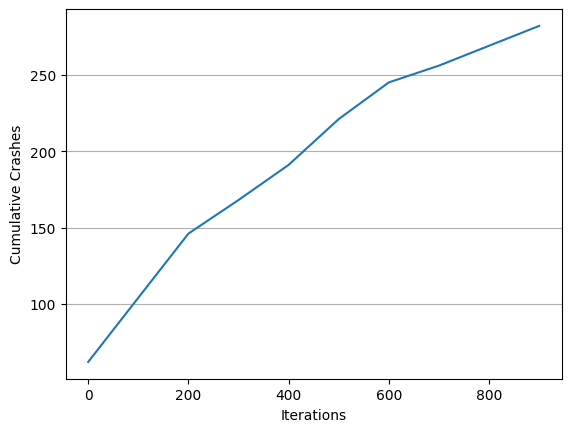

In [19]:
plot_metric_per_iteration(num_iterations, eval_interval, my_metric_log, 'Cumulative Crashes')

In [20]:
from resources import create_policy_eval_video

# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", eval_env, eval_py_env)

## Resets Agent and train again

In [21]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_py_env.update_rewards(-10., -5., 10., -1.)
eval_py_env.update_rewards(-10., -5., 10., -1.)

# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Reset Agent
agent = build_agent(fc_layer_params, env, learning_rate, train_env)
agent.initialize()

# Reset Metrics and Replay Buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()

replay_observer = [replay_buffer.add_batch, num_episodes, env_steps, my_metric]

# Reset Collect Op Driver
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

# Reset Dataset
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=train_env.batch_size,
    num_steps=2).prefetch(3)

# Reset Collect Driver
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

time_step = train_py_env.reset()
time_step, _ = collect_driver.run()

Rewards Updated: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}


### Training   

In [22]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(1)
eval_py_env.set_mode(1)
#train_env.set_mode(1)
#eval_env.set_mode(1)

# Create a driver to collect experience.
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

iterator = iter(dataset)

loss_log = []
step_log = []
steps_per_episode_log = []
episodes_per_log_interval = []
previous_n_episodes = 0

my_metric_log = []
my_metric_aux = 0

avg_steps_per_episode_per_eval_interval = []

train_py_env.print_rewards()
eval_py_env.print_rewards()

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run()

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=train_env.batch_size,
        num_steps=2).prefetch(3)
        
    # Sample a batch of data from the buffer and update the agent's network.
    trajectories, _ = next(iterator)
    train_loss = agent.train(experience=trajectories).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        #print('step = {0}: loss = {1}'.format(step, train_loss))
        step_log.append(step)
        loss_log.append(train_loss)
        episodes_per_log_interval.append(num_episodes.result().numpy() - previous_n_episodes)
        steps_per_episode_log.append(log_interval / (episodes_per_log_interval[-1]))
        previous_n_episodes = num_episodes.result().numpy()

    if step % eval_interval == 0:
        #print('step = {0}: loss = {1}'.format(step, train_loss))
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        #print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        avg_steps_per_episode_per_eval_interval.append(eval_interval / sum(episodes_per_log_interval[-10:]))
        #print('Avg of Steps/Episode: {:.2f}'.format(avg_steps_per_episode_per_eval_interval[-1]) )

        current_value = my_metric.result()
        my_metric_log.append(current_value)
        print('step = {0}: Crash = {1}'.format(step, current_value - my_metric_aux))
        my_metric_aux = current_value

Rewards: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Rewards: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
step = 100: Crash = 282
step = 200: Crash = 0
step = 300: Crash = 0
step = 400: Crash = 0
step = 500: Crash = 0
step = 600: Crash = 0
step = 700: Crash = 0
step = 800: Crash = 0
step = 900: Crash = 0
step = 1000: Crash = 0
CPU times: user 2min 39s, sys: 1.38 s, total: 2min 41s
Wall time: 2min 37s


## Visualization

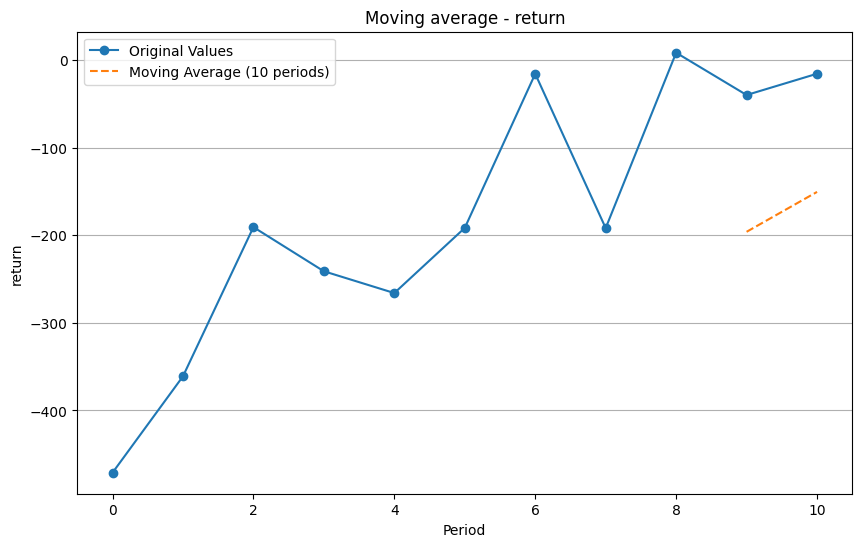

In [23]:
from resources import plot_moving_avg
plot_moving_avg('return', returns)

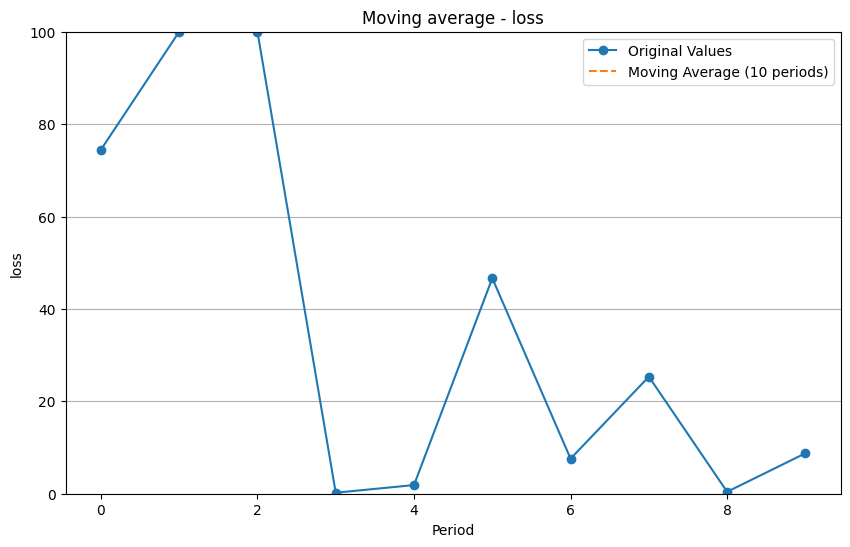

In [24]:
plot_moving_avg('loss', loss_log, ylim=True, top_lim=1_00)

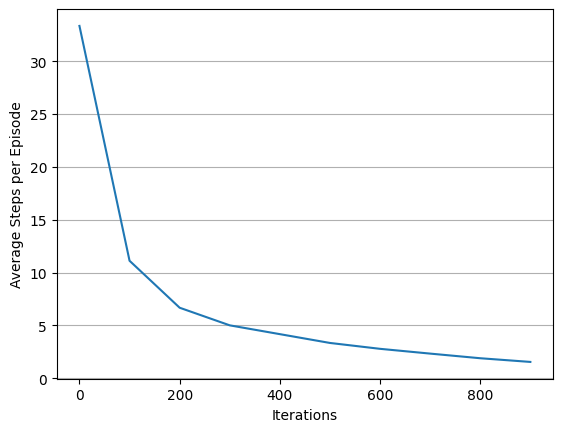

In [25]:
plot_metric_per_iteration(num_iterations, eval_interval, avg_steps_per_episode_per_eval_interval, 'Average Steps per Episode')

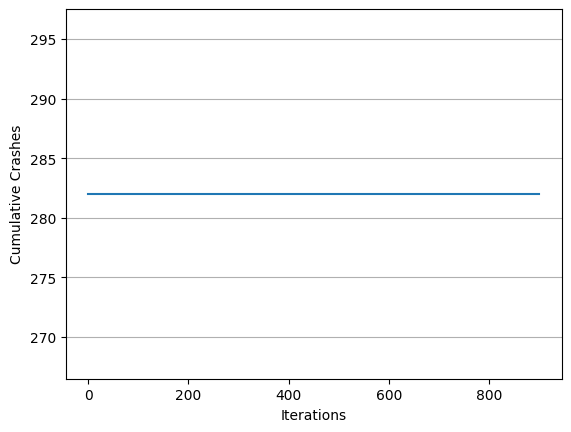

In [26]:
plot_metric_per_iteration(num_iterations, eval_interval, my_metric_log, 'Cumulative Crashes')

In [27]:
from resources import create_policy_eval_video

# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", eval_env, eval_py_env)